# AbstractSolver

This is user level application logic to define a Solver

You give it a list of transformation functions to try, and a collection of
argument literals or argument generating functions. The codes inspect to figure out
the function signatures, and generates all typesafe permutations of `functions(arguments(arguments))`

These can either be solved to exhaustion, or short-circuited to only return the first valid rule
that passes the `problem['train']` dataset.

This is still early stage code, but I think I have proved the concept
of a brute-force IoC Dependency Injection Solver

```
class OutputGridSizeSolver(AbstractSolver):
    dtype: Tuple[int,int]
    functions = [
        OutputGridSizeTransforms.identity,
        OutputGridSizeTransforms.fixed_size,
        OutputGridSizeTransforms.ratio,
    ]
    arguments = [
        Query.grid_size_ratio_task,
        Query.count_nonzero,
        Query.unique_colors,
        1/4, 1/3, 1/2, 1, 2, 3, 4,
    ]
    def preprocess( self, input: np.ndarray ) -> Any:
        return input.shape
```

API Imports

In [1]:
import time
from collections import defaultdict
from itertools import chain
from pprint import pprint

from IPython.core.display import display

from src.core.Context import Context
from src.datamodel.DataModel import Competition, Task
from src.plot import plot_task
from src.settings import settings
from src.solver_abstract.OutputGridSizeSolver import OutputGridSizeSolver

%load_ext autoreload
%autoreload 2

# Solve for a single named task

We find 3 possible rule matches

In [2]:
solver = OutputGridSizeSolver()
task   = Task('evaluation/68b67ca3.json')
rule   = solver.solve(task)
rule


[<Rule fixed_size(size=3)>, <Rule ratio(input=Symbol(input) ratio=0.5)>]

# Performance

It's a little bit slow, 7.5s to iterate over the entire competition dataset
for a single really simply solver. Maybe performance is acceptable with a 9h submit timeout.

I've also not run a profiler on this yet, and some creative caching might help significantly.

In [3]:
time_start   = time.perf_counter()
competition  = Competition()
solutions    = defaultdict(list)
solved_files = { name: [] for name in competition.keys() }
error_files  = { name: [] for name in competition.keys() }
counts       = defaultdict(int)
totals       = defaultdict(int)
for name, dataset in competition.items():
    for task in dataset:
        totals[name] += 1

        #rule  = solver.solve_one(task)
        rules = solver.solve(task)
        if not len(rules):
            error_files[name].append(task.filename)
        else:
            solutions[task.filename] += rules
            solved_files[name].append(task.filename)
            counts[name] += 1

print(f"Time Taken: {round(time.perf_counter() - time_start,2)}s")

Time Taken: 8.42s


In [4]:
print()
print('Counts')
pprint(dict(counts))
pprint(dict(totals))



Counts
{'evaluation': 321, 'test': 78, 'training': 325}
{'evaluation': 400, 'test': 100, 'training': 400}


In [5]:
solved_filenames = list(chain(*solved_files.values()))
error_filenames  = list(chain(*error_files.values()))

print('Success: ', len(solved_filenames), '/', len(solved_filenames)+len(error_filenames))
print('Errors:  ', len(error_filenames),  '/', len(solved_filenames)+len(error_filenames))

Success:  724 / 900
Errors:   176 / 900


# Viewing discovered rules

With only 6 functions and 7 literals, it was possible to correctly predict the output grid size
in about 80% of cases.

In many cases it managed to find multiple valid rules for each task.
Unsure if there needs to be some prioritization over rules, or if we simply need to deduplicate
the set of all possible valid rules.

In [6]:
settings['debug'] = False  # some rules throw exceptions when called with different data in context
print('Solutions')
print()
for filename, matching_rules in list(solutions.items())[:5]:
    if len(matching_rules):
        print(filename)
        task = Task(filename)

        for rule in matching_rules:
            for test_problem in task['test']:
                guess = rule(Context(test_problem, test_problem['input']))
                print(f"{rule} -> {guess}")
        print()

Solutions

training/e9614598.json
<Rule ratio(input=Symbol(input) ratio=1)> -> (12, 12)
<Rule ratio(input=Symbol(input) ratio=1)> -> (10, 6)
<Rule ratio(input=Symbol(input) ratio=unique_colors)> -> (12, 12)
<Rule ratio(input=Symbol(input) ratio=unique_colors)> -> (10, 6)
<Rule ratio(input=Symbol(input) ratio=grid_size_ratio_task)> -> (12, 12)
<Rule ratio(input=Symbol(input) ratio=grid_size_ratio_task)> -> (10, 6)

training/178fcbfb.json
<Rule ratio(input=Symbol(input) ratio=1)> -> (12, 11)
<Rule ratio(input=Symbol(input) ratio=grid_size_ratio_task)> -> (12, 11)

training/af902bf9.json
<Rule ratio(input=Symbol(input) ratio=1)> -> (10, 10)
<Rule ratio(input=Symbol(input) ratio=unique_colors)> -> (10, 10)
<Rule ratio(input=Symbol(input) ratio=grid_size_ratio_task)> -> (10, 10)

training/3befdf3e.json
<Rule ratio(input=Symbol(input) ratio=1)> -> (12, 12)
<Rule ratio(input=Symbol(input) ratio=grid_size_ratio_task)> -> (12, 12)

training/ac0a08a4.json
<Rule ratio(input=Symbol(input) ratio=un

## Successes

These are the first 5 examples of the problems that OutputGridSizeSolver couldn't figure out

Success:  724 / 900


[<Rule ratio(input=Symbol(input) ratio=1)>,
 <Rule ratio(input=Symbol(input) ratio=unique_colors)>,
 <Rule ratio(input=Symbol(input) ratio=grid_size_ratio_task)>]

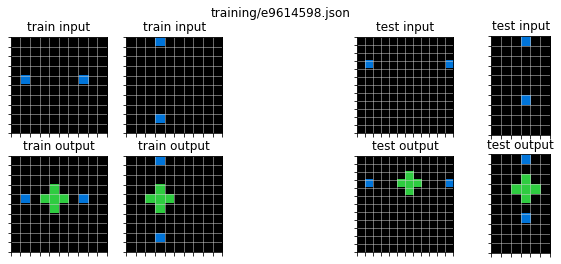

[<Rule ratio(input=Symbol(input) ratio=1)>,
 <Rule ratio(input=Symbol(input) ratio=grid_size_ratio_task)>]

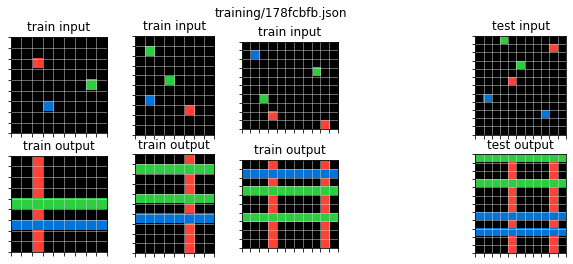

[<Rule ratio(input=Symbol(input) ratio=1)>,
 <Rule ratio(input=Symbol(input) ratio=unique_colors)>,
 <Rule ratio(input=Symbol(input) ratio=grid_size_ratio_task)>]

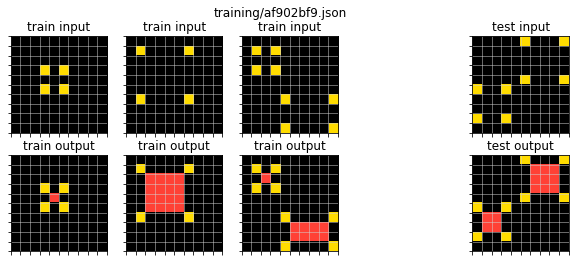

[<Rule ratio(input=Symbol(input) ratio=1)>,
 <Rule ratio(input=Symbol(input) ratio=grid_size_ratio_task)>]

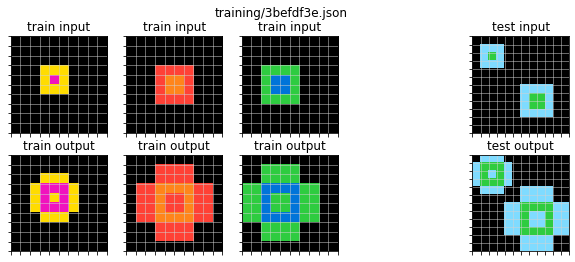

[<Rule ratio(input=Symbol(input) ratio=unique_colors)>,
 <Rule ratio(input=Symbol(input) ratio=count_nonzero)>]

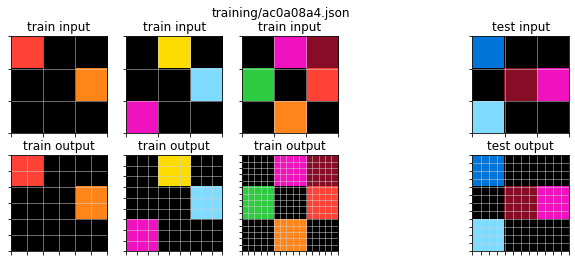

In [7]:
print('Success: ', len(solved_filenames), '/', len(solved_filenames)+len(error_filenames))

for filename in solved_filenames[:5]:
    task = Task(filename)
    display(solver.solve(task))
    plot_task(task)


## Failures

These are the first 5 examples of the problems that OutputGridSizeSolver couldn't figure out

Errors:   176 / 900


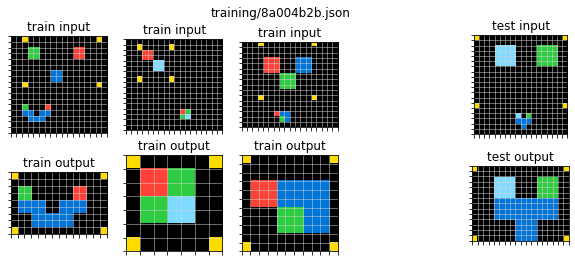

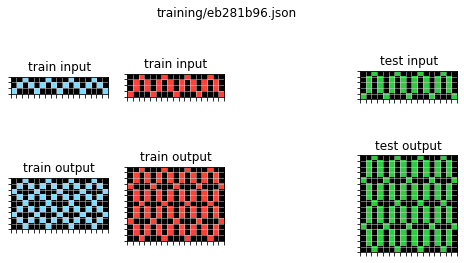

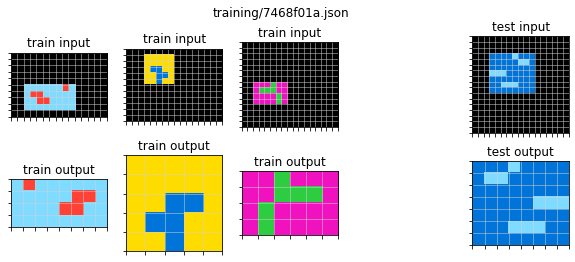

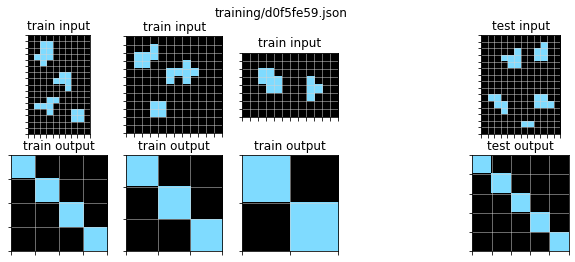

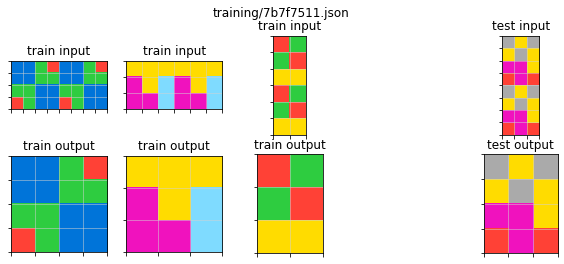

In [8]:
print('Errors:  ', len(error_filenames),  '/', len(solved_filenames)+len(error_filenames))
for filename in error_filenames[:5]:
    plot_task(Task(filename))
